In [1]:
import latentvelo as ltv
import scanpy as sc
import scvelo as scv 
import numpy as np
import torch as th
import anndata as ad

Global seed set to 0


In [2]:
adata =  sc.read('../data/Pancreas/endocrinogenesis_day15.5.h5ad')
#scv.datsets.pancreas()

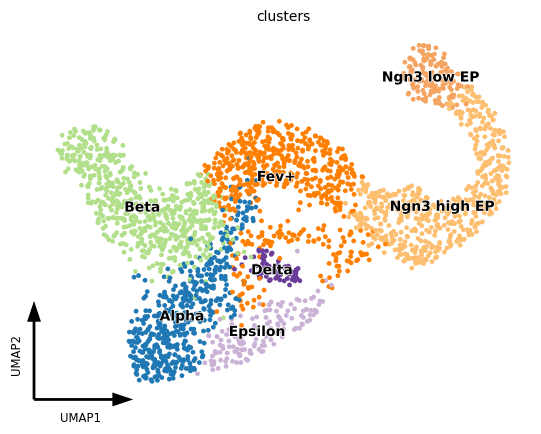

In [3]:
scv.pl.umap(adata, color='clusters', frameon='artist')

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
adata = ltv.utils.anvi_clean_recipe(adata, celltype_key='clusters')

Filtered out 22024 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
Choosing top 2000 genes
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.AnnotVAE(observed=2000, latent_dim=30, encoder_hidden=35, zr_dim=2, h_dim=3, 
                            celltypes=len(adata.obs.clusters.unique()))

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=0, name='pancreas_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
910 velocity genes used
Loading best model at 0 epochs.


In [7]:
import torch as th
model.load_state_dict(th.load('../paper_notebooks/pancreas_parameters/model_state_epoch49.params',map_location=th.device('cuda')))

<All keys matched successfully>

computing velocity graph (using 12/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


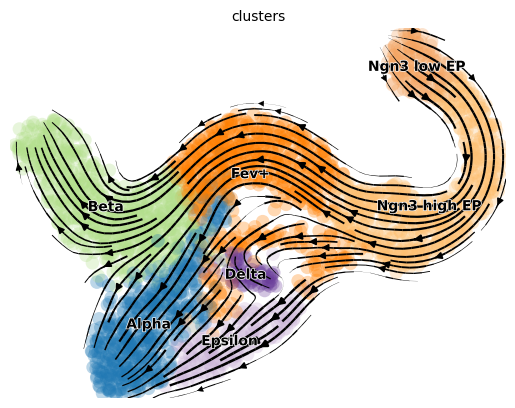

In [8]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)

scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity', n_jobs=12)
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', color='clusters')

Select latentvelo latent states and velocitiies

In [9]:
adata.obsm['X_latent'] = np.concatenate((latent_adata.layers['spliced'],
                                         latent_adata.layers['unspliced'],
                                         latent_adata.obsm['zr']), axis=-1)
adata.obsm['velocity_latent'] = np.concatenate((latent_adata.layers['spliced_velocity'],
                                         latent_adata.layers['unspliced_velocity'],
                                         latent_adata.obsm['zr_velocity']), axis=-1)

In [10]:
from dynamo.vf import VectorField
VectorField(adata, basis='latent')

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: LATENT. 
        Vector field will be learned in the LATENT space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.3280s]
|-----> <insert> velocity_latent_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_latent_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_latent to uns in AnnData Object.
|-----> <insert> control_point_latent to obs in AnnData Object.
|-----> <insert> inlier_prob_latent to obs in AnnData Object.
|-----> <insert> obs_vf_angle_latent to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [0.4904s]


In [11]:
adata.uns['VecFld_latent']['X_ctrl'].shape
# default uses 62 control points

(127, 62)

In [34]:
from umap import UMAP

umap = UMAP(min_dist=1, random_state=11).fit(adata.obsm['X_latent'][:,:model.latent])
umaplatent = umap.transform(adata.obsm['X_latent'][:,:model.latent])
adata.obsm['X_umaplatent'] = umaplatent 
latent_adata.obsm['X_umaplatent'] = umaplatent 

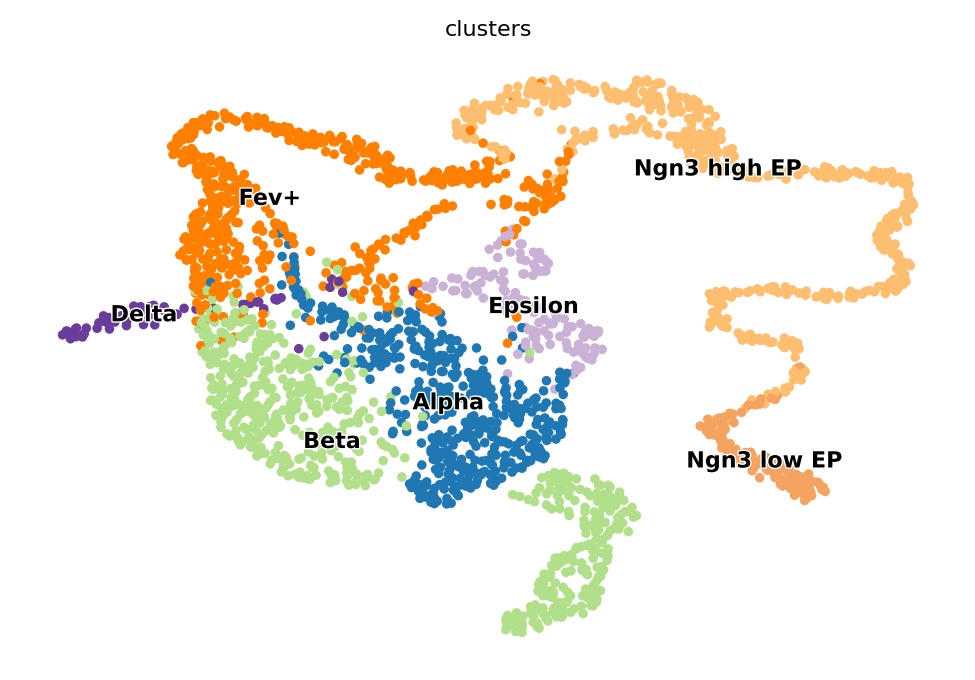

In [35]:
scv.pl.scatter(latent_adata, basis='umaplatent', color='clusters')

# Backward paths

In [36]:
adata.obs['latent_time'].max()

0.8977453

In [37]:
alpha_cells = np.where((latent_adata.obs.clusters=='Alpha') & (adata.obs['latent_time'] > 0.9*adata.obs['latent_time'].max()))[0]#[:100]
beta_cells = np.where((latent_adata.obs.clusters=='Beta') & (adata.obs['latent_time'] > 0.9*adata.obs['latent_time'].max()))[0]#[:100]
delta_cells = np.where((latent_adata.obs.clusters=='Delta') & (adata.obs['latent_time'] > 0.821*adata.obs['latent_time'].max()))[0]#[:100]
epsilon_cells = np.where((latent_adata.obs.clusters=='Epsilon') & (adata.obs['latent_time'] > 0.9*adata.obs['latent_time'].max()))[0]#[:100]
print(alpha_cells.shape, beta_cells.shape, delta_cells.shape, epsilon_cells.shape)
cells = np.concatenate((alpha_cells[:1], beta_cells[:1], delta_cells[:1], epsilon_cells[:1]))

(312,) (208,) (13,) (41,)


In [38]:
cells = np.random.choice(cells, size=4, replace=False)

In [39]:
cells

array([ 3,  4,  6, 44])

In [40]:
starting = adata.obs.index.values[cells]

In [41]:
from dynamo.pd import fate

adata = fate(adata, basis='latent', init_cells=cells, interpolation_num=250,  direction='backward',
   inverse_transform=False, t_end=100000)

uniformly sampling points along a trajectory: 100%|██████████| 4/4 [00:00<00:00, 241.24it/s]


In [42]:
adata.uns['fate_latent']

{'init_states': array([[-4.7098706e-03,  4.8367842e-03, -1.1818295e-02, -3.0593388e-04,
          1.5519050e-01, -4.5586042e-03,  4.2985762e-03, -2.7668201e-03,
          1.7968167e-01, -3.4067828e-02, -4.5087531e-02, -1.6383672e-02,
         -4.1184821e-03, -6.2324121e-03,  1.1636752e-03, -1.3574888e-04,
          5.8890684e-03, -7.2676153e-03,  1.5716043e-01, -2.6973705e-03,
         -4.6775341e-02,  3.3060618e-02,  6.5843426e-03,  7.0678279e-02,
          9.4992686e-03,  2.7112816e-03,  5.4009967e-03, -1.1713084e-02,
          7.8899115e-03, -1.6505964e-03, -3.6245704e-02, -2.0286446e-02,
          7.2373105e-03, -9.3164165e-03,  1.3080032e-03, -1.6575562e-02,
         -1.0206983e-02,  8.5746814e-03,  1.0262370e-01, -1.4868912e-02,
          3.2316573e-02,  4.3334167e-02, -5.1070689e-03,  1.3733904e-02,
          1.2473476e-03,  1.8688317e-02, -1.0475283e-02,  7.1995631e-02,
         -1.8177178e-02,  9.3734486e-04,  5.0094921e-02, -5.4913969e-03,
         -7.0542900e-04,  1.7950710e

In [43]:
adata.obsm['X_umaplatent'] = umap.transform(adata.obsm['X_latent'][:,:model.latent])

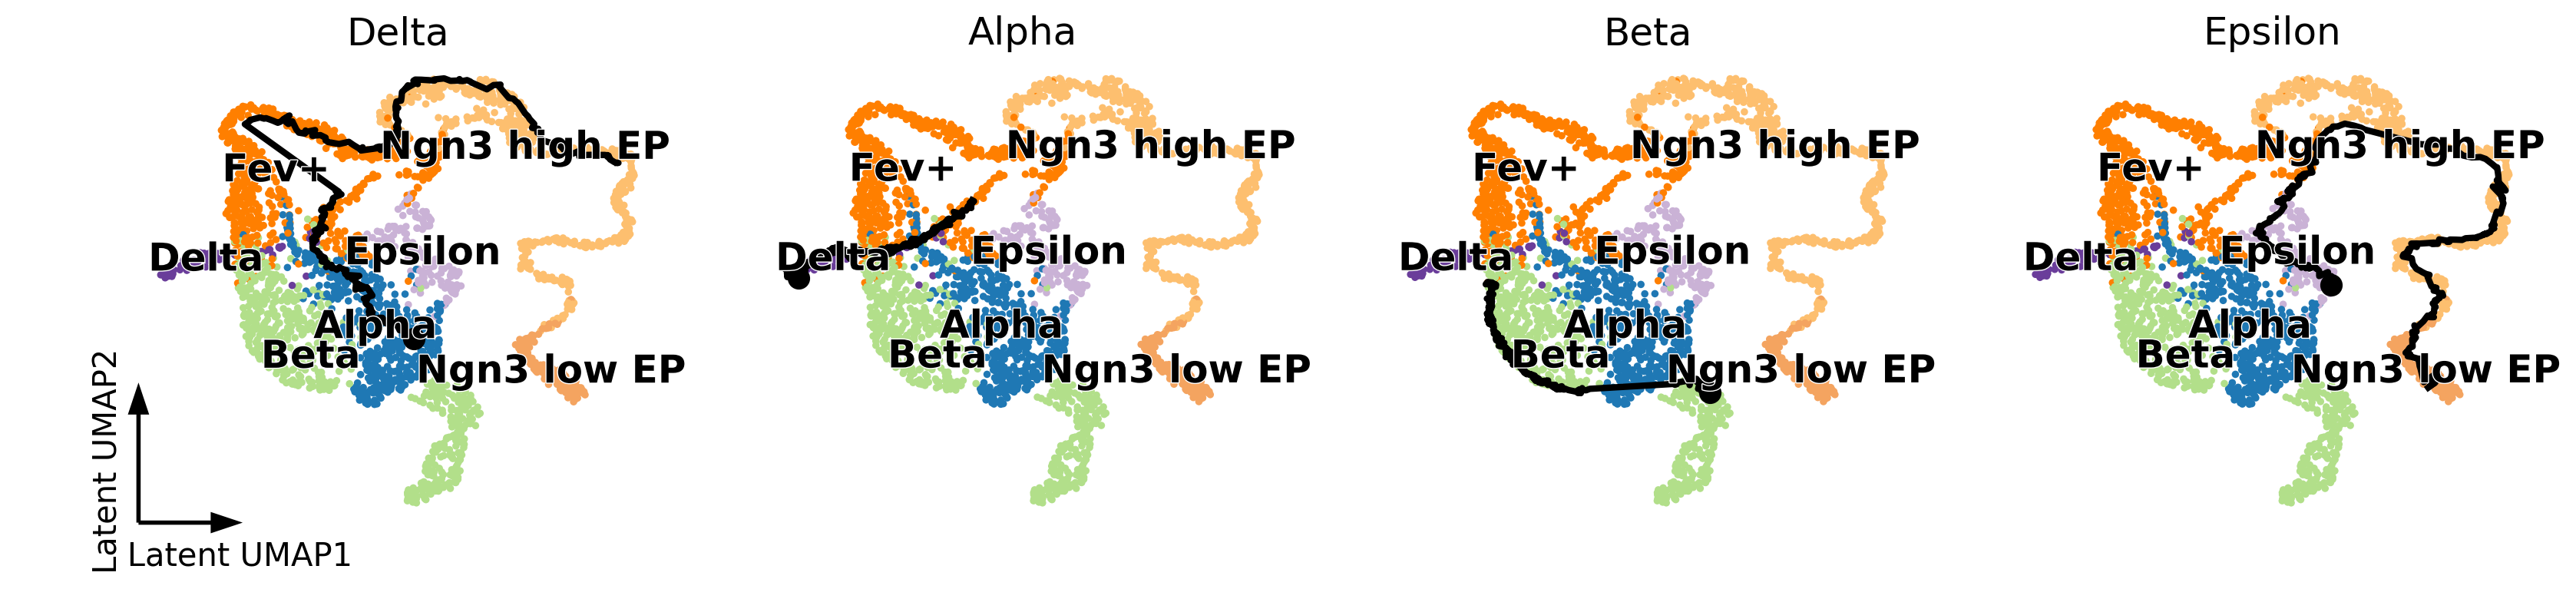

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,4,figsize=(20,4))
ax=ax.flatten()

titles = ['Delta', 'Alpha', 'Beta', 'Epsilon']

for i in range(len(cells)):
    if i == 0:
        scv.pl.scatter(adata, 'umaplatent', color='clusters',ax=ax[i], show=False,
                  fontsize=18, frameon='artist',  legend_fontsize=18, title=titles[i],
                      xlabel='           Latent UMAP1', ylabel='Latent UMAP2')#, title=[]
    else:
        scv.pl.scatter(adata, 'umaplatent', color='clusters',ax=ax[i], show=False,
                  fontsize=18, legend_fontsize=18, title=titles[i])#, title=[]
    
    X = umap.transform(adata.uns['fate_latent']['prediction'][i].T[:,:model.latent])
    X0 = umap.transform(adata.uns['fate_latent']['init_states'][i][None][:,:model.latent][:,:model.latent])
    X1 = umap.transform(latent_adata.X[cells[i]][None][:,:model.latent])
    
    ax[i].plot(X[:,0], X[:,1], color='black', lw=3)
    
    ax[i].scatter(X0[0,0], X0[0,1], color='black',s=100, marker='o')
    
plt.savefig('figures/pancreas_dynamo_backward_paths.png')
plt.show()

In [45]:
z_traj, times = ltv.cell_trajectories(model, adata, time_steps=25)

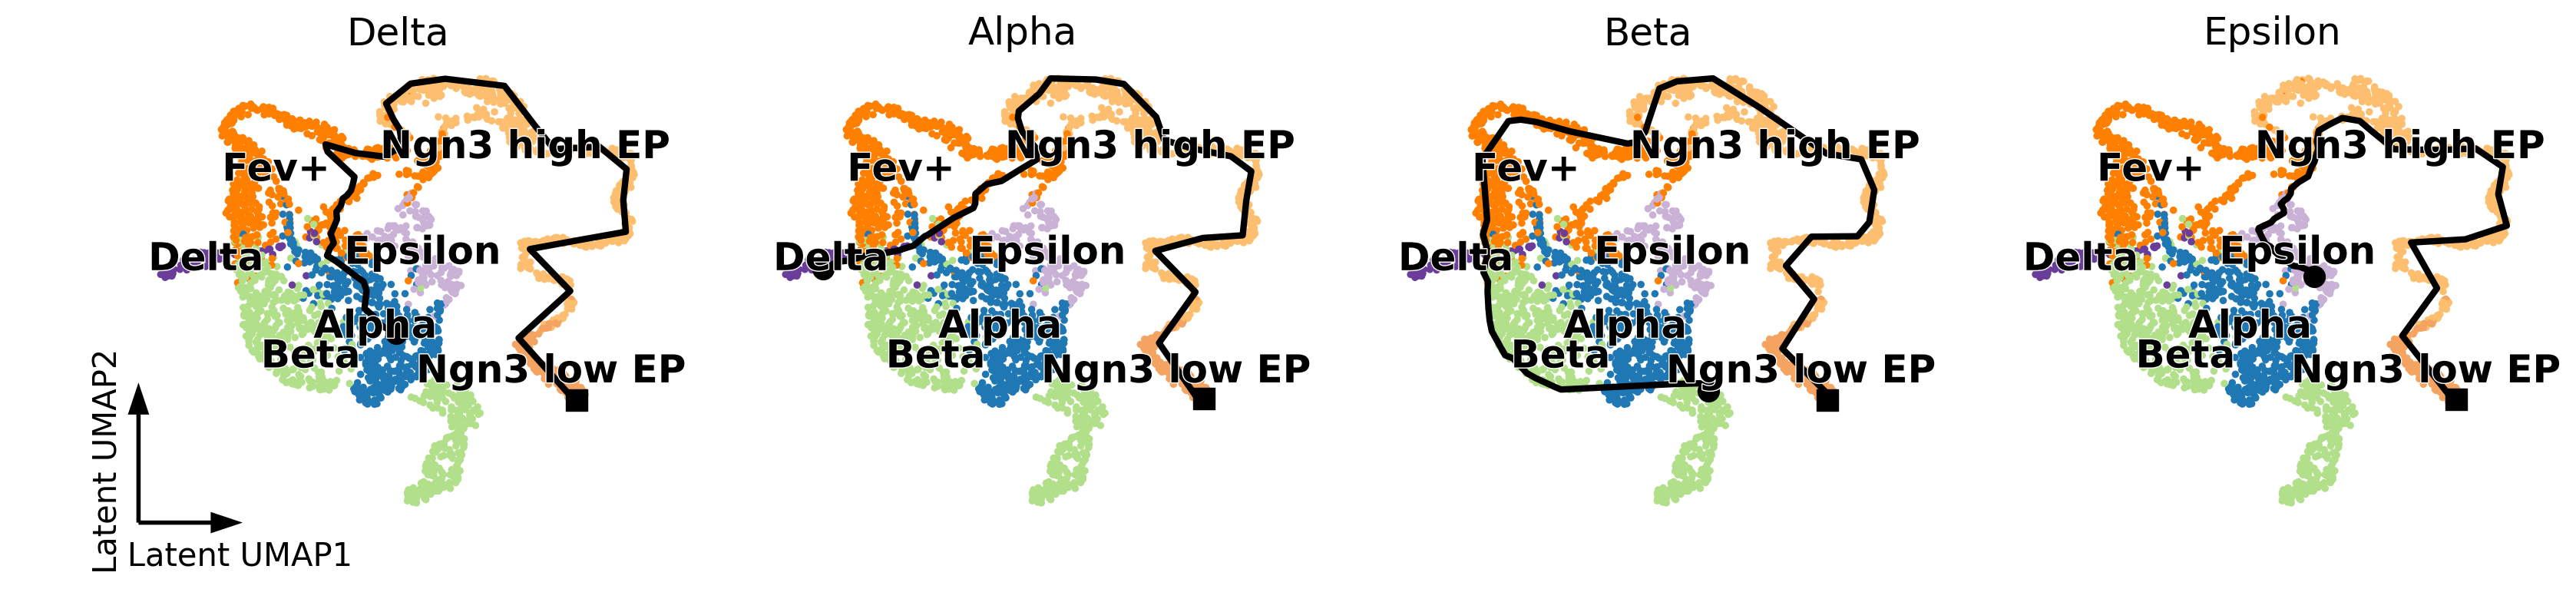

"\nax[0].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)\nax[0].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)\nax[0].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)\n\nscv.pl.umap(latent_adata, ax=ax[0], color='clusters', frameon='artist',\n           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, title='Delta',\n           legend_loc='none')\n#ax[0].titlesize(12)\nax[0].xaxis.label.set_size(9)\nax[0].yaxis.label.set_size(9)\n"

In [47]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
ax=ax.flatten()

titles = ['Delta', 'Alpha', 'Beta', 'Epsilon']

for i in range(len(cells)):
    if i == 0:
        scv.pl.scatter(adata, 'umaplatent', color='clusters',ax=ax[i], show=False,
                  fontsize=18, frameon='artist',  legend_fontsize=18, title=titles[i],
                      xlabel='           Latent UMAP1', ylabel='Latent UMAP2')#, title=[]
    else:
        scv.pl.scatter(adata, 'umaplatent', color='clusters',ax=ax[i], show=False,
                  fontsize=18, legend_fontsize=18, title=titles[i])#, title=[]
    
    X = umap.transform(z_traj[cells[i],times[cells[i],:,0]<=latent_adata.obs['latent_time'][cells[i]],:model.latent].detach().cpu().numpy())
    
    ax[i].plot(X[:,0], X[:,1], color='black', lw=3)
    ax[i].scatter(X[-1,0], X[-1,1], color='black',s=100)
    ax[i].scatter(X[0,0], X[0,1], color='black',s=100, marker='s')

plt.savefig('figures/pancreas_latentvelo_paths.png')
plt.show()

In [48]:
import dynamo as dyn
start_cells = dyn.tl.select_cell(adata, "clusters", "Ngn3 low EP")[0]
final_cells = dyn.tl.select_cell(adata, "clusters", "Beta")[-1]

In [49]:
final_cells

2526

In [50]:
dyn.tl.neighbors(adata, basis="latent", result_prefix="latent")

|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:latent
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> latent_connectivities to obsp in AnnData Object.
|-----> <insert> latent_distances to obsp in AnnData Object.
|-----> <insert> latent_neighbors to uns in AnnData Object.
|-----> <insert> latent_neighbors.indices to uns in AnnData Object.
|-----> <insert> latent_neighbors.params to uns in AnnData Object.


AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'spliced_size_factor', 'unspliced_size_factor', 'batch_id', 'celltype', 'celltype_id', 'root', 'terminal', 'latent_time', 'control_point_latent', 'inlier_prob_latent', 'obs_vf_angle_latent'
    var: 'highly_variable_genes', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_genes', 'R2', 'R2_traj', 'R2_test', 'R2_traj_test'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'scale_spliced', 'scale_unspliced', 'index_test', 'VecFld_latent', 'fate_latent', 'latent_neighbors'
    obsm: 'X_pca', 'X_umap', 'batch_onehot', 'celltype', 'X_latent', 'velocity_latent', 'velocity_latent_SparseVFC', 'X_latent_SparseVFC', 'X_umapl

In [51]:
cells, 4*[start_cells],

(array([ 3,  4,  6, 44]), [9, 9, 9, 9])

In [52]:
adata.var['use_for_pca']=True

In [53]:
x = dyn.pd.least_action(
            adata,
            4*[start_cells],
            cells,
            paired = True,
            basis="latent",
            adj_key="latent_distances",
            #EM_steps=2,
    n_points = 100
)

|-----> searching for the least action path...
|-----> [iterating through 4 pairs] in progress: 25.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.000097
|-----> [iterating through 4 pairs] in progress: 50.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.000075
|-----> [iterating through 4 pairs] in progress: 75.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.000071
|-----> [iterating through 4 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizin

In [54]:
adata.uns['LAP_latent']

{'init_states': array([[ 0.12317427,  0.06501944,  0.03830556,  0.07895032, -0.29969138,
         -0.03577896, -0.04795568, -0.0518029 , -0.41828242, -0.07324257,
         -0.0463616 ,  0.10946158,  0.16768318,  0.10102338, -0.04348103,
          0.04347452,  0.08947611,  0.03827453, -0.08270888,  0.07386275,
         -0.17554626, -0.0564896 , -0.05415336,  0.10384206, -0.06649899,
          0.04259381, -0.0196856 ,  0.08487886,  0.04424732,  0.05455733,
          0.0654038 ,  0.08223855,  0.04975972, -0.07164568,  0.09649376,
          0.14317575, -0.0498891 ,  0.0916865 ,  0.08418532,  0.16791502,
          0.08050854, -0.02085615,  0.08807329, -0.16064954, -0.03301757,
         -0.09596434, -0.02056146, -0.08537142,  0.16108632, -0.1124192 ,
         -0.13209847, -0.0622301 ,  0.07167089,  0.01258724,  0.11187206,
         -0.01397709, -0.10103264, -0.05493007, -0.13804595, -0.16103059,
         -0.16089702,  0.14877465],
        [ 0.12317427,  0.06501944,  0.03830556,  0.07895032, 

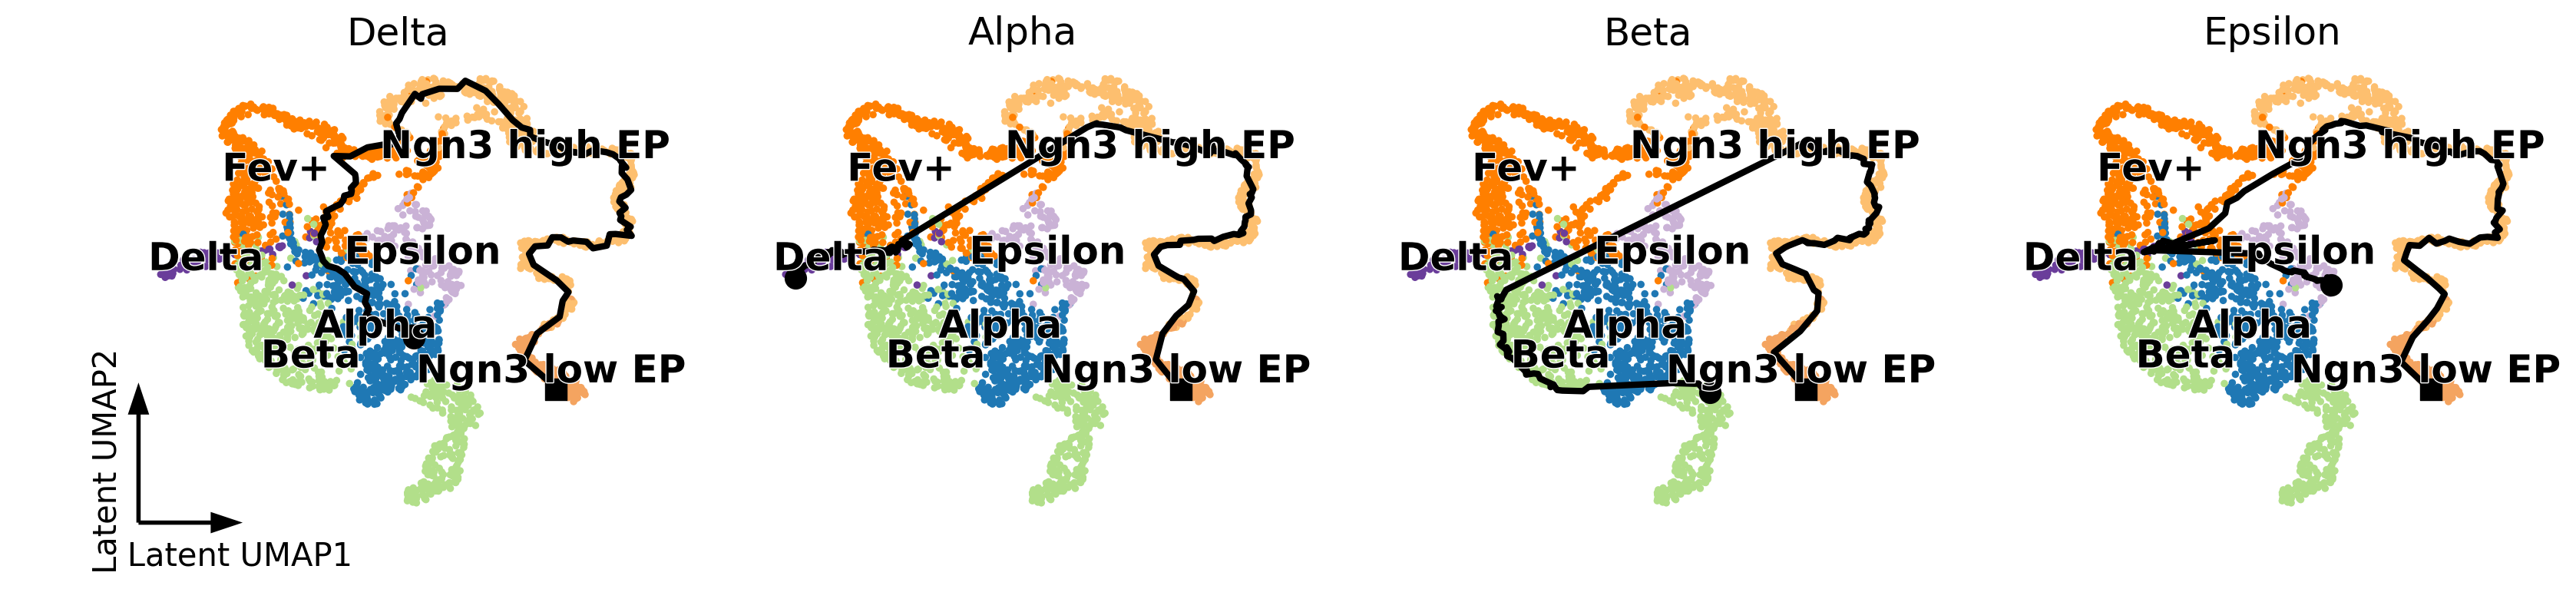

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,4,figsize=(20,4))
ax=ax.flatten()

titles = ['Delta', 'Alpha', 'Beta', 'Epsilon']

for i in range(len(cells)):
    if i == 0:
        scv.pl.scatter(adata, 'umaplatent', color='clusters',ax=ax[i], show=False,
                  fontsize=18, frameon='artist',  legend_fontsize=18, title=titles[i],
                      xlabel='           Latent UMAP1', ylabel='Latent UMAP2')#, title=[]
    else:
        scv.pl.scatter(adata, 'umaplatent', color='clusters',ax=ax[i], show=False,
                  fontsize=18, legend_fontsize=18, title=titles[i])#, title=[]
    
    X = umap.transform(adata.uns['LAP_latent']['prediction'][i][:,:model.latent])
    X0 = umap.transform(adata.uns['LAP_latent']['init_states'][i][None][:,:model.latent])
    
    X1 = umap.transform(latent_adata.X[cells[i]][None][:,:model.latent])
    
    ax[i].plot(X[:,0], X[:,1], color='black', lw=3)
    ax[i].scatter(X0[0,0], X0[0,1], color='black',s=100, marker='s')
    ax[i].scatter(X1[0,0], X1[0,1], color='black',s=100, marker='o')

plt.savefig('figures/pancreas_leastaction_paths.png')
plt.show()